# Funktion definieren um Konzentration für jeden Zeitschritt zu berechnen

In [1]:
subject = 'P08' # einziger Parameter der verändert werden sollte

#COMPARISONS = ['No_Lesion_Deep', 'No_Lesion_LR8', 'No_Lesion_GT']

#COMPARISONS = ['InVivo_Deep', 'InVivo_LR8', 'InVivo_Noisy']

COMPARISONS = ['Lesion_Deep', 'Lesion_LR8', 'Lesion_GT']

quality_clip = False # show voxels that meet LC Model quality criteria
outlier_clip = False

# Available methods:
# - P08_noDenoising
# - P08_LR8
# - P08_unet_JInvariant

# - P08_simulated_GT   -- that is ground truth
# - P08_simulated_noisy
# - P08_simulated_LR8
# - P08_simulated_unet_JInvariant

In [2]:
"""timecourse_plot.py
-----------------------------------------------------------------
Plot-Funktion für PVE‑Zeitverläufe beliebiger Metabolite & Methoden.
Baselines werden **nicht** automatisch hinzugefügt – einfach gewünschte
Methodenliste übergeben (z. B. auch 'NoDenoising' als normale Methode).
"""

from __future__ import annotations
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import nnls          # nicht‑negatives LS
from numpy.linalg import lstsq, inv

# -----------------------------------------------------------------------------
# -----------------   Hilfsfunktionen   ---------------------------------------
# -----------------------------------------------------------------------------

def fit_pve_single_metabolite(
    metabo_map: np.ndarray,           # (X,Y,Z,T)
    tissue_maps: np.ndarray,          # (X,Y,Z,3)  GM, WM, CSF
    brain_mask: np.ndarray | None = None,
    *,
    method: str = "nnls"              # "nnls" (default) oder "lstsq"
) -> tuple[np.ndarray, np.ndarray]:
    """Schätzt Metaboliten‑Konzentrationen in reinem WM, GM, CSF über die Zeit.
    Rückgabe: conc[3,T], conc_std[3,T]"""
    gm, wm, csf = (tissue_maps[..., i].ravel() for i in range(3))
    brain_mask  = np.ones_like(gm, dtype=bool).ravel() if brain_mask is None else brain_mask.ravel()

    A_full = np.vstack([wm, gm, csf]).T[brain_mask]   # (nVox, 3)
    Y      = metabo_map.reshape(-1, metabo_map.shape[-1])[brain_mask] / 1e7
    T      = Y.shape[1]

    conc, conc_std = np.empty((3, T)), np.empty((3, T))
    AtA_inv = inv(A_full.T @ A_full) if method == "lstsq" else None

    for t in range(T):
        y = Y[:, t]
        valid = (~np.isnan(y)) & (y != 0)
        A, y = A_full[valid], y[valid]
        if method == "nnls":
            x, _ = nnls(A, y)
            res  = y - A @ x
            cov  = np.linalg.pinv(A.T @ A)
        else:
            x, *_ = lstsq(A, y, rcond=None)
            res  = y - A @ x
            cov  = AtA_inv
        dof     = max(len(y) - 3, 1)
        sigma2  = (res @ res) / dof
        conc[:, t]     = x
        conc_std[:, t] = np.sqrt(sigma2 * np.diag(cov))
    return conc, conc_std


def _suffix(quality_clip: bool, outlier_clip: bool) -> str:
    """Ermittelt Dateisuffix gemäß Clip‑Flags."""
    return "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")


def _load_amp(metabolite: str, method: str, suffix: str, data_dir: str) -> np.ndarray:
    """Lädt AMP‑Map. Erwartet MetabMaps/<method>/<metabolite>_amp_<method>_<suffix>.npy"""
    path = os.path.join(data_dir, method, f"{metabolite}_amp_{method}_{suffix}.npy")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Datei fehlt: {path}")
    return np.load(path)

# -----------------------------------------------------------------------------
# -----------------   Hauptfunktion   -----------------------------------------
# -----------------------------------------------------------------------------

def plot_timecourse_metabolite(
    metabolite: str,
    methods: list[str],
    *,
    subject: str = "P08",
    quality_clip: bool = False,
    outlier_clip: bool = False,
    data_dir: str = "MetabMaps",
    tissue_dir: str = "../datasets",
    colors: tuple[str, ...] | None = None,
) -> None:
    """Plottet PVE‑Zeitverläufe (GM, WM, CSF) + GM/WM‑Ratio für einen Metaboliten.

    Args:
        metabolite:  'water', 'Glc', ...
        methods:     Liste der Denoising‑Methoden (z. B. ['NoDenoising','unet_JInvariant'])
        subject:     Datensatz‑ID (Segmentation/Maske‑Pfad)
        quality_clip / outlier_clip: bestimmt Dateisuffix (siehe _suffix)
        data_dir:    Wurzelverz. der AMP‑Maps
        tissue_dir:  Wurzelverz. der Segmentationen
        colors:      optionale Farbliste, sonst tab10‑Palette
    """
    # ---------------- Tissue‑Segmentierung laden ----------------------------
    seg_path  = os.path.join(tissue_dir, subject, "gm_wm_csf_segmentation.npy")
    mask_path = os.path.join(tissue_dir, subject, "mask.npy")
    segmentations = np.swapaxes(np.load(seg_path), 0, -2)           # (X,Y,Z,3)
    brain_mask    = np.swapaxes(np.load(mask_path), 0, -1) > 0      # (X,Y,Z)

    # ---------------- AMP‑Maps laden ---------------------------------------
    suffix = _suffix(quality_clip, outlier_clip)
    amp_maps, ok_methods = [], []
    for m in methods:
        try:
            amp_maps.append(_load_amp(metabolite, m, suffix, data_dir))
            ok_methods.append(m)
        except FileNotFoundError as e:
            print(e)
    if not amp_maps:
        raise RuntimeError("Keine AMP‑Dateien gefunden – prüfe Methoden & Suffix!")

    # ---------------- PVE‑Fitting ------------------------------------------
    conc_all, conc_sd_all = [], []
    for amp in amp_maps:
        c, c_sd = fit_pve_single_metabolite(
            amp,
            segmentations,
            brain_mask=brain_mask,
            method="nnls",
        )
        conc_all.append(c)
        conc_sd_all.append(c_sd)

    # ---------------- Plot --------------------------------------------------
    tab_colors = plt.cm.get_cmap("tab10").colors
    if colors is None:
        colors = tuple(tab_colors[i % 10] for i in range(len(ok_methods)))
    markers_tissue = ["o", "s", "^"]
    tissue_labels  = ["GM", "WM", "CSF"]
    T = conc_all[0].shape[1]
    time = np.arange(T)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # Tissue‑Plots
    for i, tissue_idx in enumerate([0, 1, 2]):
        row, col = divmod(i, 2)
        ax = axes[row, col]
        for m_idx, (c, c_sd) in enumerate(zip(conc_all, conc_sd_all)):
            ax.errorbar(
                time,
                c[tissue_idx],
                yerr=c_sd[tissue_idx],
                fmt=markers_tissue[tissue_idx],
                color=colors[m_idx],
                capsize=4,
                markersize=6,
                linestyle="none",
                label=ok_methods[m_idx] if tissue_idx == 0 else None,
            )
        ax.set_title(tissue_labels[tissue_idx])
        ax.grid(True)
        ax.set_xlabel("Zeitpunkt")
        if col == 0:
            ax.set_ylabel("Konzentration (a.u.)")

    # GM/WM‑Ratio
    ax_q = axes[1, 1]
    for m_idx, (c, c_sd) in enumerate(zip(conc_all, conc_sd_all)):
        gm, wm = c[0], c[1]
        gm_sd, wm_sd = c_sd[0], c_sd[1]
        ratio = gm / wm
        ratio_sd = ratio * np.sqrt((gm_sd / gm) ** 2 + (wm_sd / wm) ** 2)
        ax_q.errorbar(
            time,
            ratio,
            yerr=ratio_sd,
            fmt="o",
            color=colors[m_idx],
            capsize=4,
            markersize=6,
            linestyle="none",
            label=ok_methods[m_idx],
        )
    ax_q.set_title("GM / WM")
    ax_q.set_xlabel("Zeitpunkt")
    ax_q.grid(True)

    handles, labels_leg = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels_leg,
        loc="lower center",
        ncol=len(ok_methods),
        fontsize=9,
        bbox_to_anchor=(0.5, 0.02),
    )

    fig.suptitle(f"{metabolite}-Konzentrationen & GM/WM‑Kontrast ({suffix})", fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])
    plt.show()

/tmp/ipykernel_2883371/3562795209.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab_colors = plt.cm.get_cmap("tab10").colors


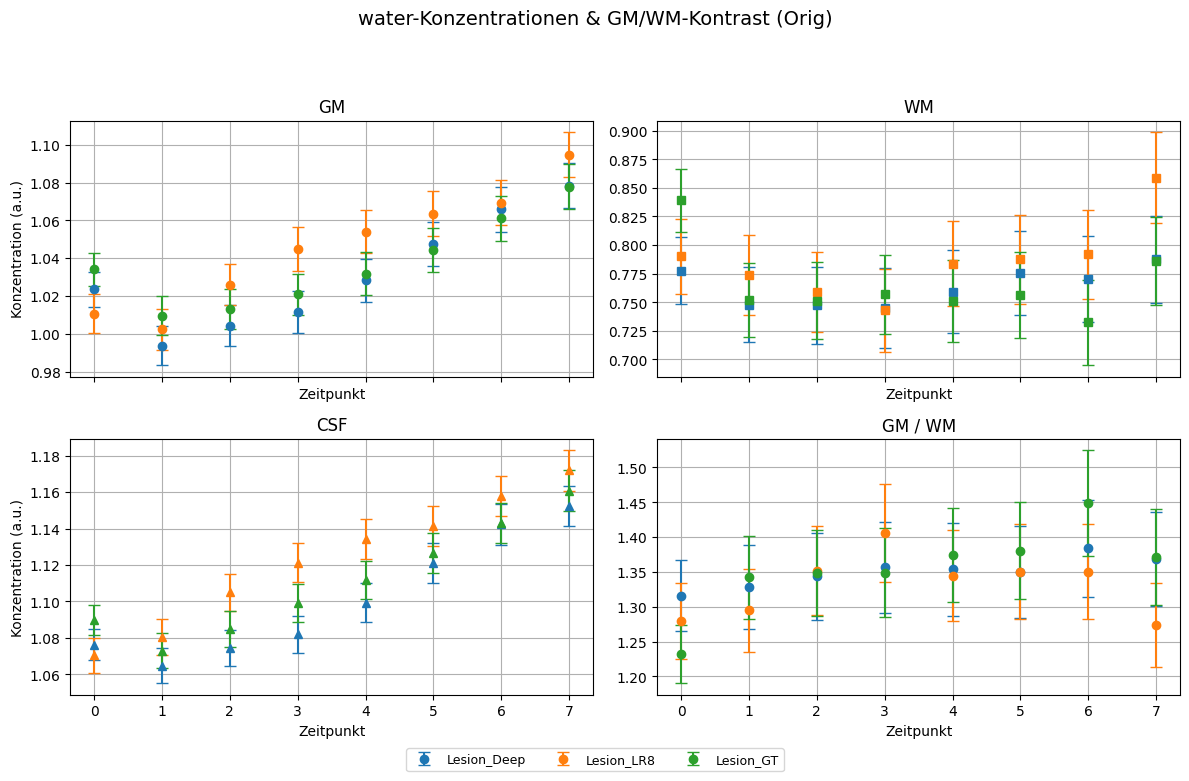

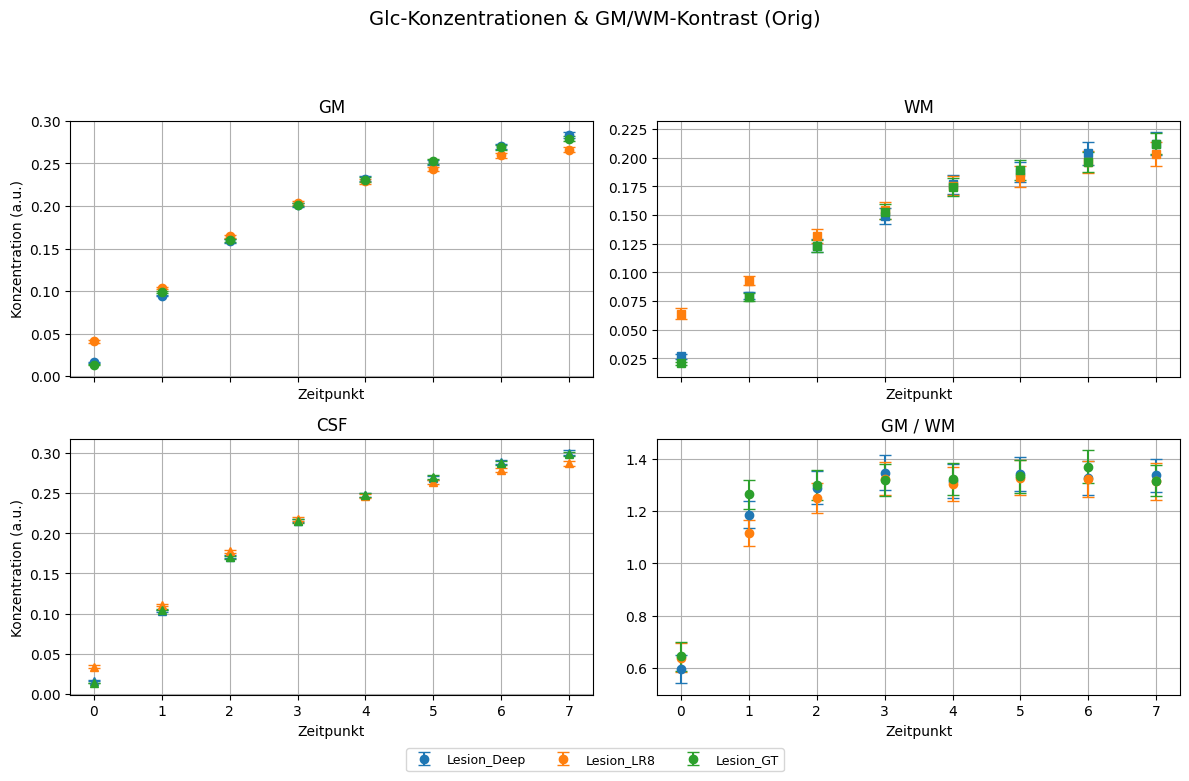

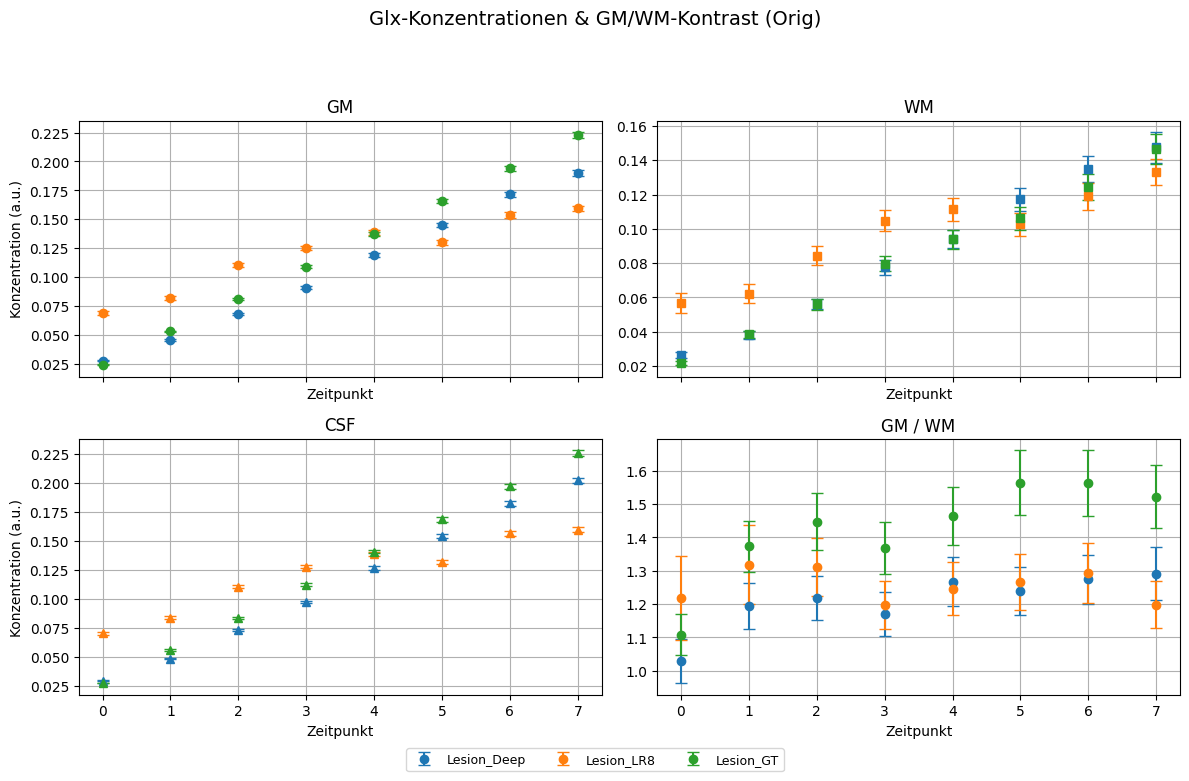

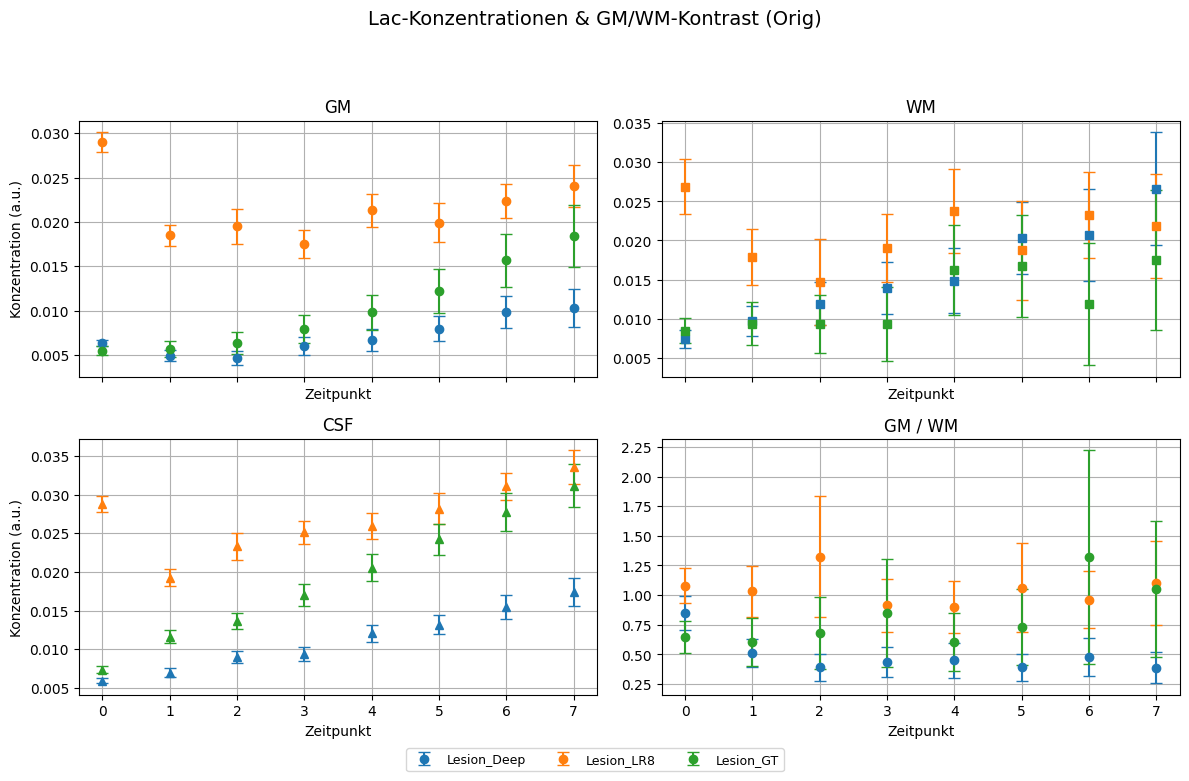

In [3]:
plot_timecourse_metabolite(
        metabolite="water",
        methods=COMPARISONS,
        quality_clip=quality_clip,
        outlier_clip=outlier_clip,
    )

plot_timecourse_metabolite(
        metabolite="Glc",
        methods=COMPARISONS,
        quality_clip=quality_clip,
        outlier_clip=outlier_clip,
    )

plot_timecourse_metabolite(
        metabolite="Glx",
        methods=COMPARISONS,
        quality_clip=quality_clip,
        outlier_clip=outlier_clip,
    )

plot_timecourse_metabolite(
        metabolite="Lac",
        methods=COMPARISONS,
        quality_clip=quality_clip,
        outlier_clip=outlier_clip,
    )